In [1]:
# 单股历史数据分析
import requests
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.ticker as ticker

In [2]:
# 对于某特定股的一些操作函数

def find_index(lst, key, value):
    for i, dic in enumerate(lst):
        if dic[key] == value:
            return i
    return -1


def check_index(lst, start, end):
    index1 = find_index(lst, 'd', start)
    index2 = find_index(lst, 'd', end)
    if index1 != -1 and index2 != -1:
        return True
    else:
        return False


def manage(df):
    df.loc[:, '涨跌'] = 0
    df['开盘价'] = df['开盘价'].astype('float')
    df['收盘价'] = df['收盘价'].astype('float')
    df['最高价'] = df['最高价'].astype('float')
    df['最低价'] = df['最低价'].astype('float')
    df['成交量'] = df['成交量'].astype('int')
    df['涨跌'] = df['涨跌'].astype('float')

    df['涨跌'] = df['收盘价'] - df.shift(1)['收盘价']
    return df

# 获取某日期区间的所有数据 以dataframe返回
# 预期输入的日期都是开盘日期（！！）
# 调用该函数前可以写一个check_date
def get_interval_data(lst, start_date, end_date):
    start = find_index(lst, 'd', start_date)
    end = find_index(lst, 'd', end_date)
    df = pd.DataFrame(columns=['日期', '开盘价', '收盘价', '最高价', '最低价', '成交量'])

    for i in range(start-1, end+1):
        date = lst[i]['d']
        open_price = lst[i]['o']
        close_price = lst[i]['c']
        high = lst[i]['h']
        low = lst[i]['l']
        vol = lst[i]['v']
        df = df.append([{'日期': date, '开盘价': open_price, '收盘价': close_price,
                       '最高价': high, '最低价': low, '成交量': vol}], ignore_index=True)
        df = manage(df)
    return df[1:]

# 获取近n天的所有数据 以dataframe返回
def get_ndays_data(lst, n):
    length = len(lst)
    df = pd.DataFrame()

    for i in range(length-n-1, length):
        date = lst[i]['d']
        open_price = lst[i]['o']
        close_price = lst[i]['c']
        high = lst[i]['h']
        low = lst[i]['l']
        vol = lst[i]['v']
        df = df.append([{'日期': date, '开盘价': open_price, '收盘价': close_price,
                       '最高价': high, '最低价': low, '成交量': vol}], ignore_index=True)
        df = manage(df)
    return df[1:]

# 获取成交量最大日信息
def get_maxVol(df):
    vol = df['成交量']
    max_arg = vol[vol == vol.max()].index
    return df.iloc[max_arg]

# 绘制个股K线、均线以及成交量柱状图
def drawStockInfo(df):
    n = len(df)
    figure, (axPrice, axVol) = plt.subplots(2, sharex=True, figsize=(15, 8))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    
    
    # K线与均线
    # 修改为mpf支持的格式
    tmp = pd.DataFrame()
    tmp['Open'] = df['开盘价']
    tmp['Close'] = df['收盘价']
    tmp['High'] = df['最高价']
    tmp['Low'] = df['最低价']
    tmp['Volumn'] = df['成交量']
    tmp['datetime'] = pd.to_datetime(df['日期'])
    mc = mpf.make_marketcolors(
        up="red", 
        down="green",
        edge="black",
        wick="black" 
    )
    tmp.set_index('datetime', inplace=True)
    style = mpf.make_mpf_style(base_mpl_style="ggplot", marketcolors=mc)
    mpf.plot(ax=axPrice, data=tmp, type='candle', style=style)
    
    axPrice.set_title("个股K线图和均线")

    if n <= 10:
        axPrice.plot(df['收盘价'].rolling(window=5).mean(),
                     color="red", label="3天均线")
    if n >= 10:
        axPrice.plot(df['收盘价'].rolling(window=5).mean(),
                     color="red", label="5天均线")
    if n >= 15:
        axPrice.plot(df['收盘价'].rolling(window=10).mean(),
                     color="blue", label="10日均线")
    if n >= 25:
        axPrice.plot(df['收盘价'].rolling(window=20).mean(),
                     color="orange", label="20日均线")

    axPrice.legend(loc='best')
    axPrice.set_ylabel("价格（单位：元）")
    axPrice.set_ylim(df['最低价'].min(), df['最高价'].max())
    axPrice.grid(True)
    # 交易量图
    for index, row in df.iterrows():
        if row['涨跌'] > 0:
            axVol.bar(row['日期'], row['成交量']/1000000, width=0.5, color='green')
        else:
            axVol.bar(row['日期'], row['成交量']/1000000, width=0.5, color='red')
    axVol.set_ylabel("成交量（单位：亿手）")
    axVol.set_title("个股成交量")
    axVol.set_ylim(0, df['成交量'].max()/1000000*1.2)
    axVol.xaxis.set_major_locator(ticker.MultipleLocator(5))
    axVol.grid(True)
    for xtick in axVol.get_xticklabels():
        xtick.set_rotation(30)
    plt.show

In [3]:
# 数据获取
code = "sh600000"
url = "https://quotes.sina.cn/cn/api/jsonp.php/var%20_{}{}=/KC_MarketDataService.getKLineData?symbol={}".format(code,code,code)
r = requests.get(url)
r.encoding = 'utf-8'

replace_str = "/*<script>location.href=\'//sina.com\';</script>*/\nvar _{}{}=(".format(code, code)
content = r.text.replace(replace_str, "")
content = content.replace(");","")
history_dict = json.loads(content)

### 操作台

In [30]:
# 1. 获取指定时间段进行数据分析例
start_date = "2015-05-20"
end_date = "2021-10-22"
if check_index(history_dict, start_date, end_date):
    df_total = get_interval_data(history_dict, start_date, end_date)
else:
    if find_index(history_dict, 'd', start_date) == -1:
        print("输入的起始时间非开盘日.")
    if find_index(history_dict, 'd', end_date) == -1:
        print("输入的结束时间非开盘日.")

# 对df_total做分析
# 获取该阶段成交量最大的一天信息
get_maxVol(df_total)

,日期,开盘价,收盘价,最高价,最低价,成交量,涨跌
29,2015-07-09,15.95,16.95,17.4,15.38,545237248,1.0


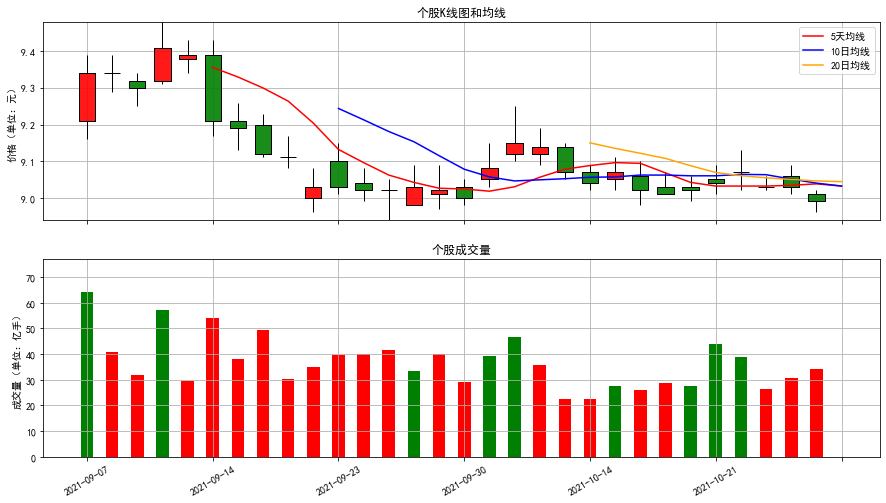

In [4]:
# 2. 对近30天数据进行K线、均线及成交量图的绘制
n = 30
df = get_ndays_data(history_dict, n)

drawStockInfo(df)